In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from geoloader01 import *

## Create a dataframe with labels

In [3]:
city_imgs = AerialCity('atlanta')
df, n_matches = city_imgs.create_df()
df.head()

['all_sat_LLAHTR', 'all_uav_LLAHTR', 'all_uav_xyzHTR', 'match_array_40', 'sat300_image_paths', 'uav_image_paths']


,uav,sat,label,is_valid
0,train/atlanta/uav/uav0.png,train/atlanta/sat300/sat0.png,1,False
1,train/atlanta/uav/uav0.png,train/atlanta/sat300/sat10.png,1,False
2,train/atlanta/uav/uav0.png,train/atlanta/sat300/sat15.png,1,False
3,train/atlanta/uav/uav1.png,train/atlanta/sat300/sat1.png,1,False
4,train/atlanta/uav/uav1.png,train/atlanta/sat300/sat28.png,1,False


In [4]:
df[n_matches-5:n_matches+5]

,uav,sat,label,is_valid
3891,train/atlanta/uav/uav2074.png,train/atlanta/sat300/sat2074.png,1,True
3892,train/atlanta/uav/uav2075.png,train/atlanta/sat300/sat2034.png,1,True
3893,train/atlanta/uav/uav2075.png,train/atlanta/sat300/sat2075.png,1,True
3894,train/atlanta/uav/uav2076.png,train/atlanta/sat300/sat2076.png,1,True
3895,train/atlanta/uav/uav2077.png,train/atlanta/sat300/sat2077.png,1,True
3896,train/atlanta/uav/uav0.png,train/atlanta/sat300/sat1294.png,0,False
3897,train/atlanta/uav/uav0.png,train/atlanta/sat300/sat622.png,0,False
3898,train/atlanta/uav/uav0.png,train/atlanta/sat300/sat861.png,0,False
3899,train/atlanta/uav/uav1.png,train/atlanta/sat300/sat690.png,0,False
3900,train/atlanta/uav/uav1.png,train/atlanta/sat300/sat1874.png,0,False


## Create dataset
Images are normalized internally. Satellite images are normalized with `(mean,std)` of satellite images, whereas uav images are normalized with `(mean,std)` of uav images.

In [5]:
train_ds, valid_ds = get_ds(df)

In [6]:
# dataset index, image-vs-label index, uav-vs-sat index
train_ds[0][0][0].shape # 0-1

torch.Size([3, 224, 224])

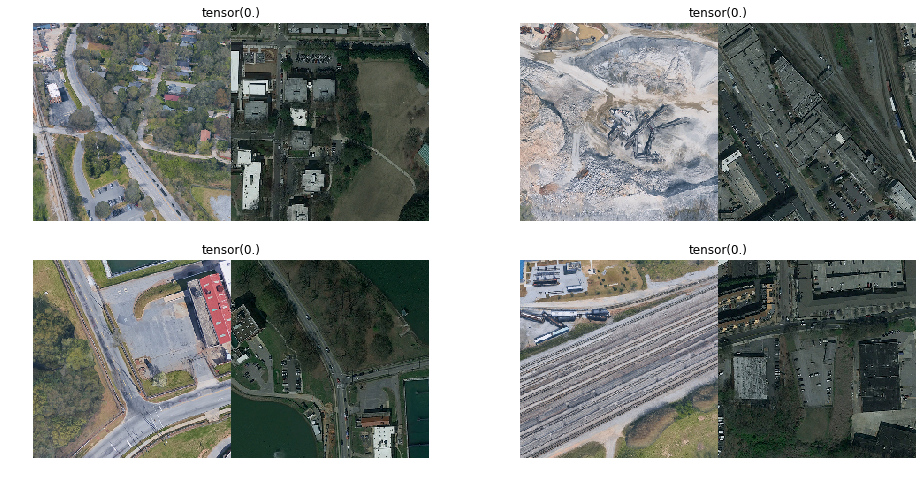

In [7]:
show_ex(train_ds,rows=2, shuffle=True)

In [8]:
bs = 32
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False)
data = DataBunch(train_dl, valid_dl)

In [9]:
GEres18 = models.resnet18(pretrained = True) # resnets are initialized with imagenet weights
GMres18 = models.resnet18(pretrained = True)
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x
GEres18.fc = Identity()
GMres18.fc = Identity()

class DualResnet18(nn.Module):
    def __init__(self):
        super(DualResnet18, self).__init__()
        self.GE = GEres18
        self.GM = GMres18
    def forward(self, img1, img2):
        o1 = self.GE(img1)
        o2 = self.GM(img2)
        output = torch.norm(o1-o2, p=2, dim=1)
        return output

arch = DualResnet18()
arch = arch.to('cuda')

### Contrastive Loss Function 

In [10]:
def loss_contrastive(euclidean_distance, label_batch):
    margin = 100
    loss = torch.mean( (label_batch) * torch.pow(euclidean_distance, 2) +
                    (1-label_batch) * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))
    return loss

## Get, Set, GO Train!!!

In [11]:
learn = Learner(data, arch, loss_func=loss_contrastive)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.31E-01


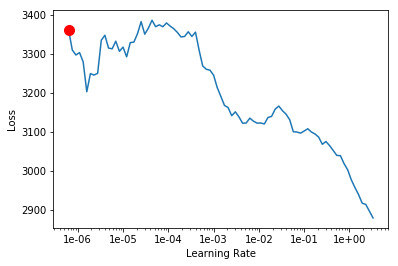

In [12]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [13]:
learn.fit_one_cycle(100, max_lr=1e-3, callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='01b_dual_res_kaiming_best')])

epoch,train_loss,valid_loss,time
0,2748.714111,3448.274658,06:12
1,2203.432373,3648.206055,06:22
2,1933.333984,3575.133057,06:37
3,1747.115112,3386.496094,06:31
4,1598.116211,3215.609619,06:28
5,1522.531494,3324.326660,06:31
6,1453.085693,3666.841553,06:18
7,1384.191772,2792.363525,06:21
8,1296.103882,2978.524902,06:33
9,1288.327881,2702.368652,06:27


Better model found at epoch 0 with valid_loss value: 3448.274658203125.
Better model found at epoch 3 with valid_loss value: 3386.49609375.
Better model found at epoch 4 with valid_loss value: 3215.609619140625.
Better model found at epoch 7 with valid_loss value: 2792.363525390625.
Better model found at epoch 9 with valid_loss value: 2702.36865234375.
Better model found at epoch 16 with valid_loss value: 2623.485107421875.


[autoreload of tqdm._utils failed: Traceback (most recent call last):
  File "/home/abhinavtripathi_iitk/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/home/abhinavtripathi_iitk/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    update_generic(old_obj, new_obj)
  File "/home/abhinavtripathi_iitk/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 331, in update_generic
    update(a, b)
  File "/home/abhinavtripathi_iitk/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 289, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/abhinavtripathi_iitk/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 331, in update_generic
    update(a, b)
  File "/home/abhinavtripathi_iitk/anaconda3/lib/python3.7/site-packages/IPython/extensions/autore

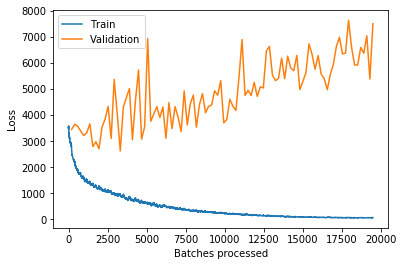

In [14]:
learn.recorder.plot_losses()

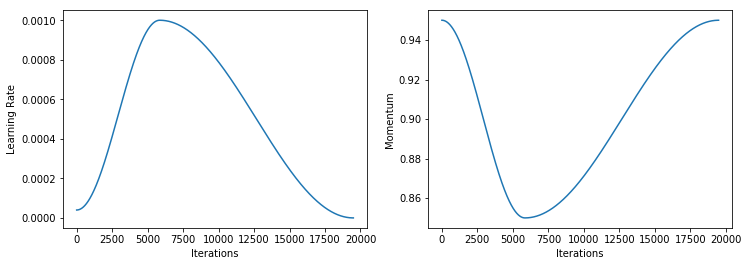

In [15]:
learn.recorder.plot_lr(show_moms=True)

In [16]:
learn.save('01b_dual_res_imagenet')

In [17]:
from tqdm.notebook import tqdm

In [18]:
arch = learn.model
arch.eval()
def histo(dl, dset):
    matdist, nmatdist = [], []
    for xb,yb in tqdm(dl):
        imuav, imsat = xb[0].cuda(), xb[1].cuda()
        eucd = arch(imuav, imsat)
        mask0 = (yb==0)
        mask1 = (yb==1)
        nmatdist.extend(eucd[mask0].cpu().detach().numpy())
        matdist. extend(eucd[mask1].cpu().detach().numpy())

    mathist  = plt.hist( matdist, range(int(np.ceil(max( matdist)))), label = 'matching pairs', alpha = 0.7)
    nmathist = plt.hist(nmatdist, range(int(np.ceil(max(nmatdist)))), label = 'non-matching pairs', alpha = 0.7)
    plt.legend(loc='best')
    plt.title(dset + ' data')
    plt.xlabel('Distance between image pairs')
    plt.show()

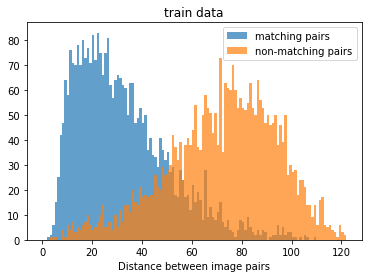

In [19]:
histo(train_dl, 'train')

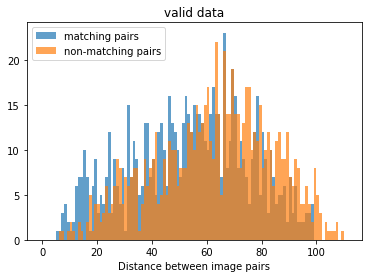

In [20]:
histo(valid_dl, 'valid')